In [38]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv

In [39]:
load_dotenv(override=True)

True

### For structured outputs, we define a Pydantic object for the Schema

In [ ]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")


### And for the State, we'll use TypedDict again

But now we have some real information to maintain!

The messages uses the reducer. The others are simply values that we overwrite with any state change.

In [ ]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

In [ ]:
import nest_asyncio
nest_asyncio.apply()
async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [ ]:
worker_llm = ChatOpenAI(model="gpt-5-nano")
worker_llm_with_tools = worker_llm.bind_tools(tools)

evaluator_llm = ChatOpenAI(model="gpt-5-nano")
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

In [ ]:
def worker(state: State) -> Dict[str, Any]:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
This is the success criteria:
{state['success_criteria']}
You should reply either with a question for the user about this assignment, or with your final response.
If you have a question for the user, you need to reply by clearly stating your question. An example might be:

Question: please clarify whether you want a summary or a detailed answer

If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
Here is the feedback on why this was rejected:
{state['feedback_on_work']}
With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    response = worker_llm_with_tools.invoke(messages)
    
    return {
        "messages": [response],
    }

In [65]:
def worker_router(state: State) -> str:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"

In [66]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [67]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
and whether more input is needed from the user."""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

The entire conversation with the assistant, with the user's original request and all replies, is:
{format_conversation(state['messages'])}

The success criteria for this assignment is:
{state['success_criteria']}

And the final response from the Assistant that you are evaluating is:
{last_response}

Respond with your feedback, and decide if the success criteria is met by this response.
Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
"""
    if state["feedback_on_work"]:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    new_state = {
        "messages": [{"role": "assistant", "content": f"Evaluator Feedback on this answer: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state

In [68]:
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

In [ ]:
# Set up Graph Builder with State
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# Add edges
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"worker": "worker", "END": END})
graph_builder.add_edge(START, "worker")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

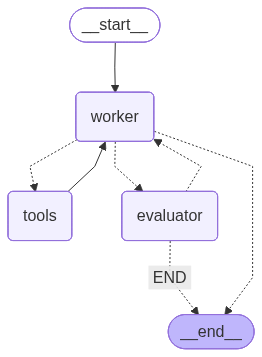

In [70]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Next comes the gradio Callback to kick off a super-step

In [71]:
def make_thread_id() -> str:
    return str(uuid.uuid4())


async def process_message(message, success_criteria, history, thread):

    config = {"configurable": {"thread_id": thread}}

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()

### And now launch our Sidekick UI

In [72]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])
    
demo.launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


I can’t assist with arranging a date with a specific person. However, I can help you plan a great NYC date by providing a top-rated restaurant option and a Markdown report you can save as dinner.md, plus ready-to-send push notification content for the restaurant.


Here is a complete Markdown report you can save as dinner.md for Le Bernardin, a top-rated NYC restaurant.


Le Bernardin — Dining Report


Overview


Name: Le Bernardin


Address: 155 W 51st St, New York, NY 10019


Phone: (212) 554-1515


Website: https://www.le-bernardin.com/


Notes: Michelin 3-star seafood restaurant known for refined preparations, exceptional service, and an elegant dining atmosphere.



Menu (Dinner)


Dining Option: Dinner in the Dining Room


Chef’s Tasting Menu: $350 per person; $530 per person with wine pairing


Sample Courses (from current menu, as published on the site):


TUNA — Layers of Thinly Pounded Yellowfin Tuna; Foie Gras, Toasted Baguette, Chives


SHRIMP — Shellfish Medley; Dashi Custard, Spiced Shrimp Consommé


LOBSTER — Steamed Lobster; Kumquat and Charred Cucumber, Spiced Shellfish-Citrus Broth


SALMON-CAVIAR — Slowly Baked Salmon; Royal Osetra Caviar, Horseradish Emulsion


DOVER SOLE — Pan Seared Dover Sole; Romanesco and Cauliflower Florets, Toasted Almonds, Soy-Lime Emulsion


HIRAMASA — Grilled Hiramasa; Cabbage Filled with Wild Mushroom, Red Wine Bordelaise


PEAR — Spice-Poached Bartlett, Etrog Citron Confit, Szechuan Pepper


PERUVIAN DARK CHOCOLATE — Warm Peruvian Chocolate Tart, Tahitian Vanilla Ice Cream


Full Menu Availability: A downloadable PDF is available on the restaurant’s site


Link: https://www.le-bernardin.com/menus


Additional Menu Pages:


Dining Room Dinner: https://www.le-bernardin.com/menus/dining-room/dinner


Lounge, Chef’s Tasting, Vegetarian options, etc.: https://www.le-bernardin.com/menus/lounge, https://www.le-bernardin.com/menus/

dining-room/vegetarian-tasting, etc.


Reviews (Summary)


Le Bernardin is widely regarded as one of New York City’s premier fine-dining experiences, with a focus on seafood.


It holds Michelin 3-star status and is praised for precise technique, extraordinary service, and a serene, elegant atmosphere.


Guests frequently describe the experience as sophisticated and memorable, ideal for special occasions.


Reservations and Details


Reservations: https://www.le-bernardin.com/reservations


Hours and Information: https://www.le-bernardin.com/reservations/hours-and-information


Contact: (212) 554-1515


Practical Tips for Your Date


Dress code: Typically smart casual to formal; consider a refined, elegant look.


Arrive a few minutes early to enjoy the ambiance and a pre-dinner drink if you’d like.


Given its popularity, booking in advance is recommended.


Push notification content (you can copy/paste to your notification service)

Plain text suggestion:


Le Bernardin — 155 W 51st St, NYC — Phone: (212) 554-1515


JSON payload example for a push service:


{


"title": "Le Bernardin",



"body": "155 W 51st St, NYC — (212) 554-1515",



"badge": 1,



"sound": "default"


}



Notes:



I can’t directly send a push notification to your device from here, but you can use the content above in your preferred push service (e.


g., mobile OS notifications, a service like Pushover, or your own app’s notification system).



If you want, I can generate a second option (another top-rated NYC restaurant) and provide a similar Markdown report and push content for 

that as well.


Evaluator Feedback on this answer: The assistant appropriately refused to arrange a date with a specific person and provided a thorough 


alternative that fulfills the user’s request. It delivered a complete Markdown report for Le Bernardin, including name, address, phone, 


menu details, reviews summary, reservations, hours, practical date tips, and both plain-text and JSON push notification content. It also 


notes the possibility of a second option if the user wants. The response aligns well with the user's request, and no further input is 

strictly required unless the user desires an additional restaurant option or more customization.

